In [5]:
import kagglehub
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

In [6]:
# Download a mirror of CIFAR-10 that has images extracted into folders
# This version by 'swaroopkml' puts images in folders named by their class (e.g., 'dog', 'airplane')
# This creates a structure compatible with torchvision.datasets.ImageFolder
path = kagglehub.dataset_download("swaroopkml/cifar10-pngs-in-folders")

print(f"Data downloaded to: {path}")

Data downloaded to: /Users/deepakramalingam/.cache/kagglehub/datasets/swaroopkml/cifar10-pngs-in-folders/versions/1


Train path: /Users/deepakramalingam/.cache/kagglehub/datasets/swaroopkml/cifar10-pngs-in-folders/versions/1/cifar10/cifar10/train
Test path:  /Users/deepakramalingam/.cache/kagglehub/datasets/swaroopkml/cifar10-pngs-in-folders/versions/1/cifar10/cifar10/test
--- Training Data Samples ---


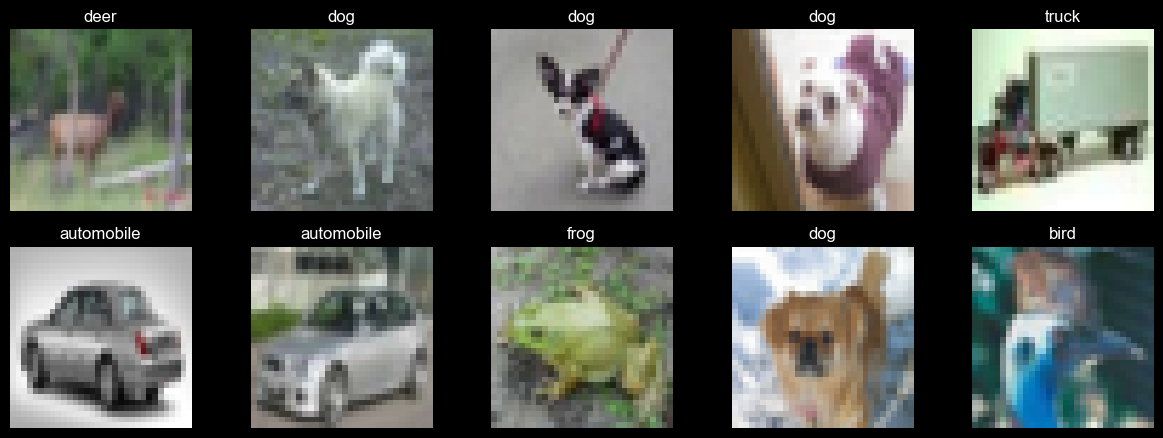

In [7]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# 1. Update the paths with the double 'cifar10' folder
# We can construct it relative to the 'path' variable you already have
base_dir = os.path.join(path, 'cifar10', 'cifar10')
train_path = os.path.join(base_dir, 'train')
test_path = os.path.join(base_dir, 'test')

print(f"Train path: {train_path}")
print(f"Test path:  {test_path}")

# 2. Reuse our helper functions
def get_random_images(root_path, num_images=5):
    images = []
    titles = []

    if not os.path.exists(root_path):
        print(f"Error: Path still not found: {root_path}")
        return [], []

    classes = [d for d in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, d))]

    for _ in range(num_images):
        random_class = random.choice(classes)
        class_path = os.path.join(root_path, random_class)
        files = os.listdir(class_path)
        if len(files) > 0:
            random_file = random.choice(files)
            img = Image.open(os.path.join(class_path, random_file))
            images.append(img)
            titles.append(f"{random_class}")

    return images, titles

def show_images(images, title_texts):
    if not images: return
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(15, 8))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image)
        plt.title(title_text, fontsize=12)
        plt.axis('off')
        index += 1
    plt.show()

# --- Verification ---
print("--- Training Data Samples ---")
train_imgs, train_labels = get_random_images(train_path, num_images=10)
show_images(train_imgs, train_labels)

In [8]:
# 1. init random weights
# 2. loop:
#     2a. predict
#     2b. loss function
#     2c. gradient
#     2d. update weights

# 0. create dataset
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # 50% chance to flip
    transforms.RandomCrop(32, padding=4), # Shift image slightly
    transforms.ToTensor(),
    # Normalize is crucial for convergence!
    # These are the standard means/stds for CIFAR-10
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
train_dataset = ImageFolder(root=train_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 1. Define the CNN Architecture
# We use a class structure because it handles the transition from
# 3D (Conv layers) to 1D (Linear layers) much cleaner than nn.Sequential.
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Conv Block 1: 3 Input Channels (RGB) -> 32 Filters
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)

        # Conv Block 2: 32 -> 64 Filters
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # Conv Block 3: 64 -> 128 Filters
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Pooling layer to shrink image size (32 -> 16 -> 8 -> 4)
        self.pool = nn.MaxPool2d(2, 2)

        # Fully Connected Layers (Classifier)
        # Image starts at 32x32. After 3 pools, it is 4x4.
        # We have 128 filters, so flattened size is 128 * 4 * 4 = 2048
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10) # 10 Output classes

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # Apply Convolutions + ReLU + Pooling
        # Input: [Batch, 3, 32, 32]
        x = self.pool(F.relu(self.conv1(x))) # -> [Batch, 32, 16, 16]
        x = self.pool(F.relu(self.conv2(x))) # -> [Batch, 64, 8, 8]
        x = self.pool(F.relu(self.conv3(x))) # -> [Batch, 128, 4, 4]

        # FLATTEN: This is where we go from 3D images to 1D vectors
        x = x.view(-1, 128 * 4 * 4)

        # Classifier
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x) # Output logits
        return x

# Initialize the model
net = SimpleCNN()

# optimizer
opt = optim.Adam(net.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.1)

# criterion
criterion = nn.BCEWithLogitsLoss()
loss = None

# 2. loop
epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        # 2a. predict
        # flatten
        target_one_hot_encoding = F.one_hot(labels, num_classes=10).float()
        # y_pred are the logits
        y_pred = net(images)
        # 2b. loss function
        loss = criterion(y_pred, target_one_hot_encoding)
        # 2c. gradient
        opt.zero_grad()
        loss.backward()
        # 2d. update weights
        opt.step()
        running_loss += loss.item()
    scheduler.step()
    print(f"Epoch {epoch+1} complete. Avg Loss: {running_loss/len(train_loader):.4f}")

Epoch 1 complete. Avg Loss: 0.2446
Epoch 2 complete. Avg Loss: 0.1858
Epoch 3 complete. Avg Loss: 0.1581
Epoch 4 complete. Avg Loss: 0.1436
Epoch 5 complete. Avg Loss: 0.1336
Epoch 6 complete. Avg Loss: 0.1262
Epoch 7 complete. Avg Loss: 0.1199
Epoch 8 complete. Avg Loss: 0.1156
Epoch 9 complete. Avg Loss: 0.1116
Epoch 10 complete. Avg Loss: 0.1089


Evaluating...

Overall Accuracy: 77.28%


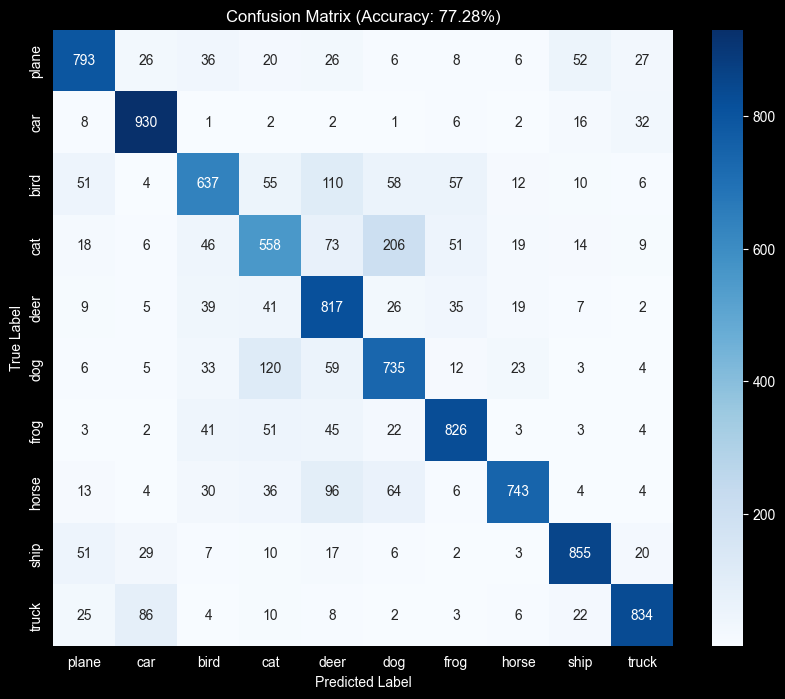

array([[793,  26,  36,  20,  26,   6,   8,   6,  52,  27],
       [  8, 930,   1,   2,   2,   1,   6,   2,  16,  32],
       [ 51,   4, 637,  55, 110,  58,  57,  12,  10,   6],
       [ 18,   6,  46, 558,  73, 206,  51,  19,  14,   9],
       [  9,   5,  39,  41, 817,  26,  35,  19,   7,   2],
       [  6,   5,  33, 120,  59, 735,  12,  23,   3,   4],
       [  3,   2,  41,  51,  45,  22, 826,   3,   3,   4],
       [ 13,   4,  30,  36,  96,  64,   6, 743,   4,   4],
       [ 51,  29,   7,  10,  17,   6,   2,   3, 855,  20],
       [ 25,  86,   4,  10,   8,   2,   3,   6,  22, 834]])

In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score # Added accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Ensure test_path and transform are defined in your environment
test_dataset = ImageFolder(root=test_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def evaluate_confusion_matrix(model, loader, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []

    print("Evaluating...")
    with torch.no_grad():
        for images, labels in loader:
            # Flatten images [Batch, 3072]
            # Get model outputs (logits)
            logits = model(images)

            # Convert logits to probabilities (0-1)
            probs = torch.sigmoid(logits)

            # Get the predicted class index (highest probability)
            _, preds = torch.max(probs, 1)

            # Append predictions and labels to lists
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # --- NEW: Calculate and Print Accuracy ---
    acc = accuracy_score(all_labels, all_preds)
    print(f"\nOverall Accuracy: {acc * 100:.2f}%")
    # -----------------------------------------

    # Calculate Confusion Matrix using sklearn
    cm = confusion_matrix(all_labels, all_preds)

    # Plot using Seaborn
    plt.figure(figsize=(10, 8))

    # Create the heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names if class_names else "auto",
                yticklabels=class_names if class_names else "auto")

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix (Accuracy: {acc*100:.2f}%)') # Added accuracy to title too
    plt.show()

    return cm

# --- Example Usage ---

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Run the function
# (Ensure 'net' is your trained model and test_loader is defined)
evaluate_confusion_matrix(net, test_loader, class_names=classes)